# Procesos estocásticos en tiempo continuo

El ajuste a datos reales se logra con reescalamiento y combinación de procesos simulados de Weiner.
Empiezo por simulación de procesos individuales.


0.0001 0.0001


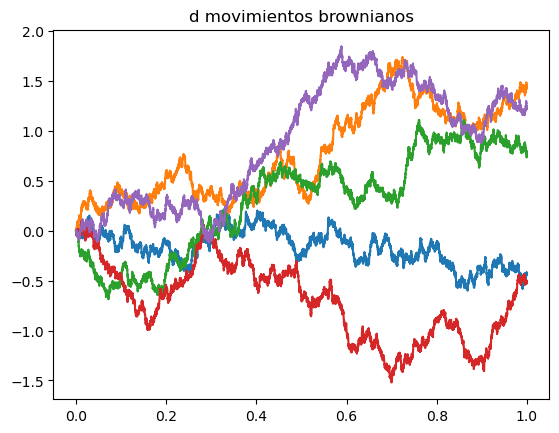

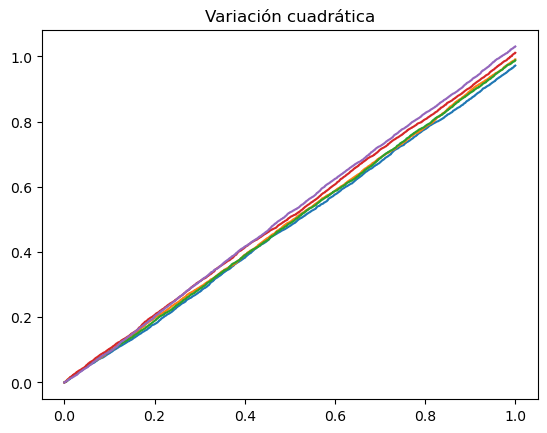

In [7]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_dW(n: int, Ts: float=1 , d: int =1, random_state: Optional[int] = None) -> np.ndarray:
    """
    Una matriz de d columnas, cada una siendo un vector de n muestreos de tiempos de una distribución
    normal para simular incrementos discretos dW de un proceso de Weiner o Mov Browninano.
    Optional random_state to reproduce results.
    Asumo tiempo de muestreo Ts constante por lo que la varianza de las muestras es
    constante (1 por defecto).
    """
    np.random.seed(random_state)
    sample=np.random.normal(0.0, Ts**(1/2), (n-1,d))#Ts es la varianza
    W_0=np.zeros((1,d)) #Fila de ceros. Cada proceso (columna) se inicializa en 0
    dW=np.concatenate((W_0,sample),axis=0) #Agrego el punto inicial 0 de partida (para cada vector)
    return dW

def get_W(n: int, Ts: float=1, d:int = 1,random_state: Optional[int] = None) -> np.ndarray:
    """
    Simula d movimientos Brownianos de n muestras sampleadas en intervalos Ts unidades de tiempo.
    Retorna cada columnda de la matriz como el vector de sumas acumuladas.
    """
    dW = get_dW(n,Ts=Ts,d=d,random_state=random_state)  
    
    return np.cumsum(dW,axis=0) #Cum sum retorna un vector y cada entrada se convierte en la suma acumulada

def quadratic_variation(W):
    """Devuelve la matriz con las variaciones cuadráticas de cada columna (mov browniano) de W"""
    return np.cumsum(np.power(np.diff(W,axis=0,prepend=0),2),axis=0)
T=1#Horizonte de tiempo
n=10000
d=5
time=np.linspace(0,T,n+1)#Con n+1 puntos obtengo 0=t_0<...<t_n=T, n subintervalos
Ts=T/n
print(Ts,time[1]-time[0])
B=get_W(n+1,Ts,d=d)
plt.plot(time,B)
plt.title("d movimientos brownianos")
plt.show()
plt.plot(time,quadratic_variation(B))
plt.title("Variación cuadrática")
plt.show()

(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 [Text(0, -10.0, '−10'),
  Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35')])

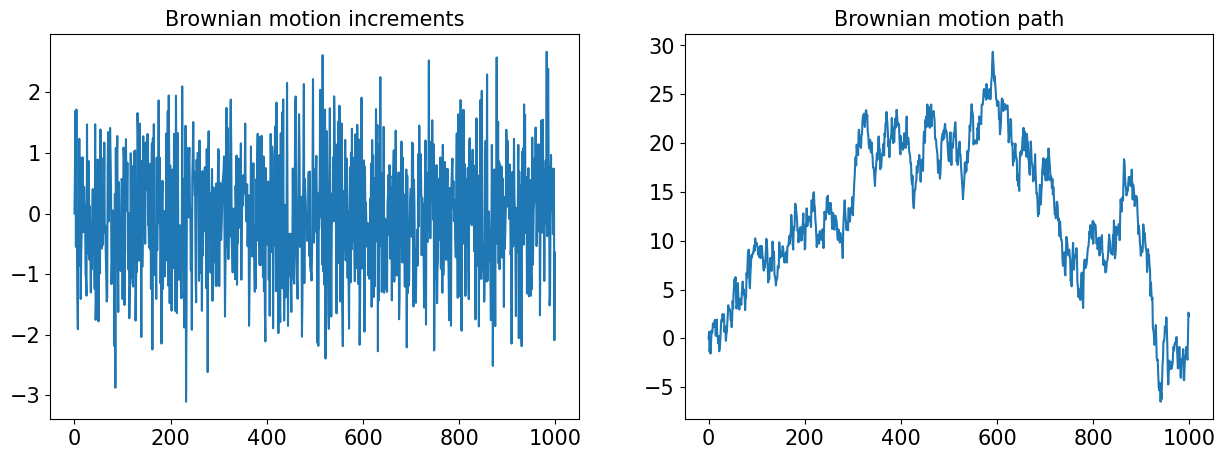

In [8]:
#simulación individual
dW = get_dW(1_000)
W = get_W(1_000)

fig = plt.figure(figsize=(15, 5))

title = "Brownian motion increments"
plt.subplot(1, 2, 1)
plt.plot(dW)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Brownian motion path"
plt.subplot(1, 2, 2)
plt.plot(W)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Correlacionados
$W_3$ correlacionado con $W_1$. Con la relación $$dW_3(t)=\rho dW_1(t)+\sqrt{1-\rho^2}dW_1(t)$$
Se tiene que $corr(W_1,W_3)=\rho$.

Usualmente necesitaré múltiplos procesos. El segundo proceso correlacionado por $\rho$ con el primero, el segundo correlacionado por $\rho$ con una elección aleatoria de los procesos ya generados. Simularé una matriz con cada columna como un proceso de Weiner. 

In [11]:


#############################################################################33
#Métodos viejos para que funcione la última parte del código que obtiene matriz con correlaciones. 
#Cambiar para que funcione con los nuevos


def get_dW(T: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Sample T times from a normal distribution,
    to simulate discrete increments (dW) of a Brownian Motion.
    Optional random_state to reproduce results.
    """
    np.random.seed(random_state)
    sample=np.random.normal(0.0, 1.0, T-1)
    dW=np.insert(sample,0,0)
    return dW

def get_W(T: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Simula un movimiento Browuniano sampleado en unidades de tiempo.
    Returns the cumulative sum
    """
    dW = get_dW(T, random_state)
    return np.cumsum(dW) #Cum sum retorna un vector y cada entrada se convierte en la suma acumulada

######################################################################
#####################################################################3




def _get_correlated_dW(dW: np.ndarray, rho: float, random_state: Optional[int] = None) -> np.ndarray:
    """
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dW2 = get_dW(len(dW), random_state=random_state)  # generate Brownian icrements.
    if np.array_equal(dW2, dW):
        # dW cannot be equal to dW2.
        raise ValueError("Brownian Increment error, try choosing different random state.")
    return rho * dW + np.sqrt(1 - rho ** 2) * dW2



#Métodos auxiliares para matriz:

def _get_random_state_i(random_state: Optional[int], i: int) -> Optional[int]:
    """Add i to random_state if is int, else return None."""
    return random_state if random_state is None else random_state + i


def _get_corr_ref_dW(
    dWs: list[np.ndarray], i: int, rng: np.random.Generator
) -> np.ndarray:
    """
    Choose randomly a process (dW) the from the
    already generated processes (dWs).
    """
    random_proc_idx = rng.choice(i)
    return dWs[random_proc_idx]

def get_corr_dW_matrix(
    n: int,
    n_procs: int,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Matriz con n_procs Brownianos dW, cada uno compuesto por n muestras de incrementos discretos.
    Cada columna será un proceso, por lo que resulta una matriz (n, n_procs).
    rho es la correlación con la que se simularán los procesos a partir de alguno de los anteriormente simulados (proceso elegido por la función _get)

    """
    rng = np.random.default_rng(random_state)
    dWs: list[np.ndarray] = []
    for i in range(n_procs):
        random_state_i = _get_random_state_i(random_state, i)
        if i == 0 or rho is None:
            dW_i = get_dW(n, random_state=random_state_i)
        else:
            dW_corr_ref = _get_corr_ref_dW(dWs, i, rng)
            dW_i = _get_correlated_dW(dW_corr_ref, rho, random_state_i)
        dWs.append(dW_i)
    return np.asarray(dWs).T
    



(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5]),
 [Text(0, 0.5, '0'),
  Text(0, 2.5, '2'),
  Text(0, 4.5, '4'),
  Text(0, 6.5, '6'),
  Text(0, 8.5, '8'),
  Text(0, 10.5, '10'),
  Text(0, 12.5, '12'),
  Text(0, 14.5, '14'),
  Text(0, 16.5, '16'),
  Text(0, 18.5, '18'),
  Text(0, 20.5, '20'),
  Text(0, 22.5, '22'),
  Text(0, 24.5, '24'),
  Text(0, 26.5, '26'),
  Text(0, 28.5, '28'),
  Text(0, 30.5, '30'),
  Text(0, 32.5, '32'),
  Text(0, 34.5, '34'),
  Text(0, 36.5, '36'),
  Text(0, 38.5, '38'),
  Text(0, 40.5, '40'),
  Text(0, 42.5, '42'),
  Text(0, 44.5, '44'),
  Text(0, 46.5, '46'),
  Text(0, 48.5, '48'),
  Text(0, 50.5, '50'),
  Text(0, 52.5, '52')])

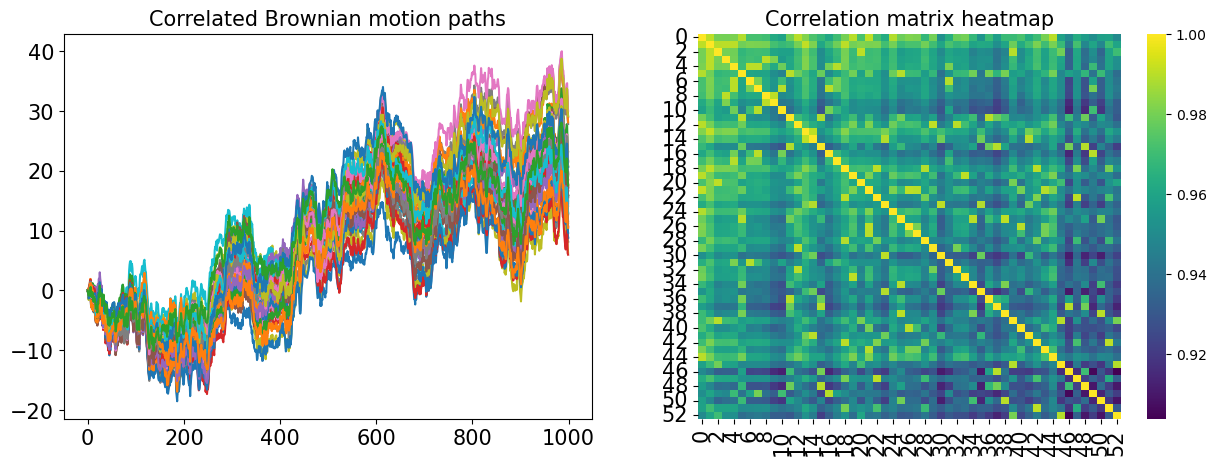

In [12]:
T = 1_000
n_procs = 53
rho = 0.99

corr_dWs = get_corr_dW_matrix(T, n_procs, rho)


#Plot
fig = plt.figure(figsize=(15, 5))

# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(corr_dWs, axis=0))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Correlation matrix heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(corr_dWs, rowvar=False), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)